In [2]:
!pip install seaborn transformers scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 8.8 MB/s eta 0:00:00a 0:00:01


In [3]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
df = pd.read_csv('/home/raghuraam/Documents/Projects/spotify/archive/spotify_history.csv')
df.head(10)

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False
5,50VNvhzyaSplJCKWchN7a8,2013-07-08 03:17:52,web player,63485,Impossible,James Arthur,Impossible,clickrow,clickrow,False,False
6,1I4EczxGBcPR3J3KeyqFJP,2013-07-08 03:17:56,web player,0,We Own The Sky,M83,Saturdays = Youth,nextbtn,nextbtn,False,False
7,5arVt2Wg0zbiWwAOZef2Nl,2013-07-08 03:17:56,web player,1268,Higher Ground - Remastered 2003,Red Hot Chili Peppers,Mother's Milk,nextbtn,nextbtn,False,False
8,1ixtaZc0Adil3yD1ItPqSl,2013-07-08 03:17:58,web player,0,Happy Up Here,Röyksopp,Happy Up Here,nextbtn,nextbtn,False,False
9,2v5mpowLQNFN7NC46l0bJS,2013-07-08 03:19:11,web player,0,Phantom,Justice,Phantom,nextbtn,clickrow,False,False


In [7]:
df['ts'] = pd.to_datetime(df['ts'])
df['hour'] = df['ts'].dt.hour
df['minute'] = df['ts'].dt.minute
df['seconds_played'] = df['ms_played'] / 1000
df['minutes_played'] = df['seconds_played'] / 60

In [9]:
print("=== SPOTIFY LISTENING DATA ANALYSIS ===\n")
# Basic Statistics
print("-" * 50)
print(f"Total tracks: {len(df)}")
print(f"Unique artists: {df['artist_name'].nunique()}")
print(f"Unique albums: {df['album_name'].nunique()}")
print(f"Total listening time: {df['minutes_played'].sum():.1f} minutes")
print(f"Average play time per track: {df['minutes_played'].mean():.1f} minutes")
print(f"Skip rate: {(df['skipped'].sum() / len(df) * 100):.1f}%")
print()

=== SPOTIFY LISTENING DATA ANALYSIS ===

--------------------------------------------------
Total tracks: 149860
Unique artists: 4113
Unique albums: 7948
Total listening time: 320492.2 minutes
Average play time per track: 2.1 minutes
Skip rate: 5.3%



In [10]:
# Artist Analysis
print("2. ARTIST ANALYSIS")
print("-" * 50)
artist_stats = df.groupby('artist_name').agg({
    'track_name': 'count',
    'minutes_played': 'sum',
    'ms_played': 'mean'
}).round(2)
artist_stats.columns = ['track_count', 'total_minutes', 'avg_ms_played']
artist_stats = artist_stats.sort_values('track_count', ascending=False)
print(artist_stats)
print()

2. ARTIST ANALYSIS
--------------------------------------------------
                  track_count  total_minutes  avg_ms_played
artist_name                                                
The Beatles             13621       20169.74       88846.97
The Killers              6878       17659.28      154050.09
John Mayer               4855       12086.99      149375.79
Bob Dylan                3814        9490.94      149306.87
Paul McCartney           2697        5955.91      132500.69
...                       ...            ...            ...
twuan                       1           1.70      101982.00
warner case                 1           3.39      203330.00
Louis Silva Band            1           2.72      163377.00
Louis The Child             1           1.49       89576.00
Louise Farrenc              1           5.54      332133.00

[4113 rows x 3 columns]



In [11]:
# Listening Patterns
print("3. LISTENING PATTERNS")
print("-" * 50)
hourly_pattern = df.groupby('hour').agg({
    'track_name': 'count',
    'minutes_played': 'sum'
}).round(2)
hourly_pattern.columns = ['track_count', 'total_minutes']
print("By Hour:")
print(hourly_pattern)
print()

3. LISTENING PATTERNS
--------------------------------------------------
By Hour:
      track_count  total_minutes
hour                            
0           10884       21870.05
1            9395       19213.02
2            9029       17374.23
3            8550       16585.26
4            6355       14050.94
5            7164       13729.92
6            7369       13448.10
7            4412        8504.60
8            2312        5035.43
9            1695        3480.94
10           1207        2493.93
11            903        1774.60
12            724        1755.00
13           1658        3804.54
14           2759        6814.48
15           3725        9396.06
16           6737       16403.86
17           9194       23031.05
18           8945       23060.83
19           8165       21140.90
20          10494       21667.94
21           8953       18385.34
22           8715       16833.81
23          10516       20637.34



In [12]:
# Reason Analysis
print("4. USER BEHAVIOR ANALYSIS")
print("-" * 50)
print("Start reasons:")
print(df['reason_start'].value_counts())
print("\nEnd reasons:")
print(df['reason_end'].value_counts())
print()

4. USER BEHAVIOR ANALYSIS
--------------------------------------------------
Start reasons:
reason_start
trackdone     76655
fwdbtn        53793
clickrow      11228
appload        3729
backbtn        2205
playbtn        1458
remote          477
trackerror      120
unknown          23
nextbtn          21
popup             5
endplay           2
autoplay          1
Name: count, dtype: int64

End reasons:
reason_end
trackdone                       77194
fwdbtn                          53470
endplay                         10119
logout                           4367
backbtn                          2182
unexpected-exit-while-paused     1725
unknown                           268
remote                            224
unexpected-exit                   118
clickrow                           34
nextbtn                            21
appload                             7
popup                               6
reload                              4
trackerror                          4
Name: count, d

In [14]:
# Clean up artist names to remove special characters like '$'
df['artist_name'] = df['artist_name'].str.replace('$', '', regex=False)

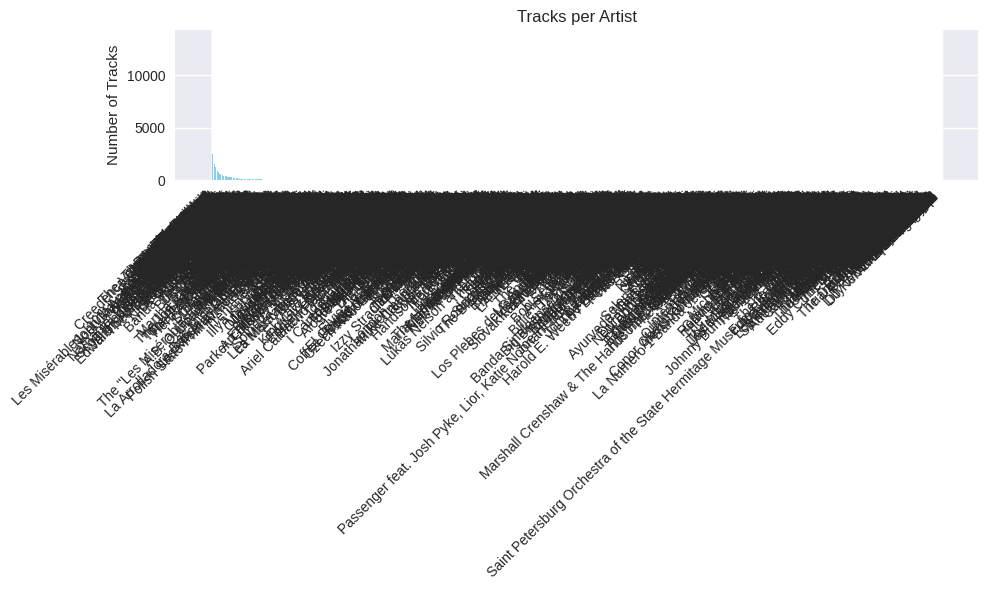

In [ ]:
# 1. Artist popularity
plt.figure(figsize=(10, 6))
artist_counts = df['artist_name'].value_counts()
plt.bar(range(len(artist_counts)), artist_counts.values, color='skyblue')
plt.xticks(range(len(artist_counts)), artist_counts.index, rotation=45, ha='right')
plt.title('Tracks per Artist')
plt.ylabel('Number of Tracks')
plt.tight_layout()

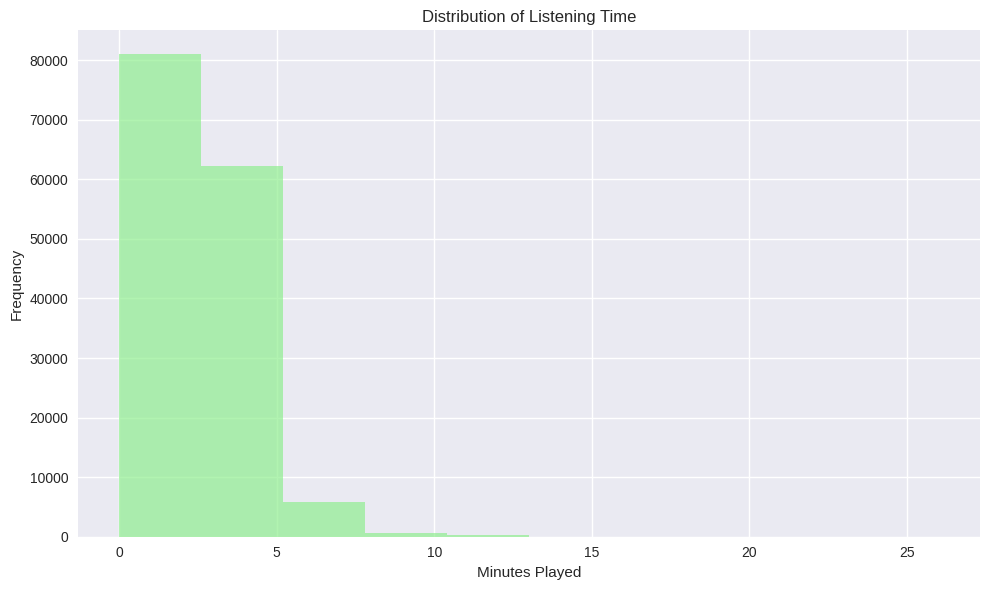

In [17]:
# 2. Listening time distribution
plt.figure(figsize=(10, 6))
plt.hist(df['minutes_played'], bins=10, color='lightgreen', alpha=0.7)
plt.title('Distribution of Listening Time')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.tight_layout()

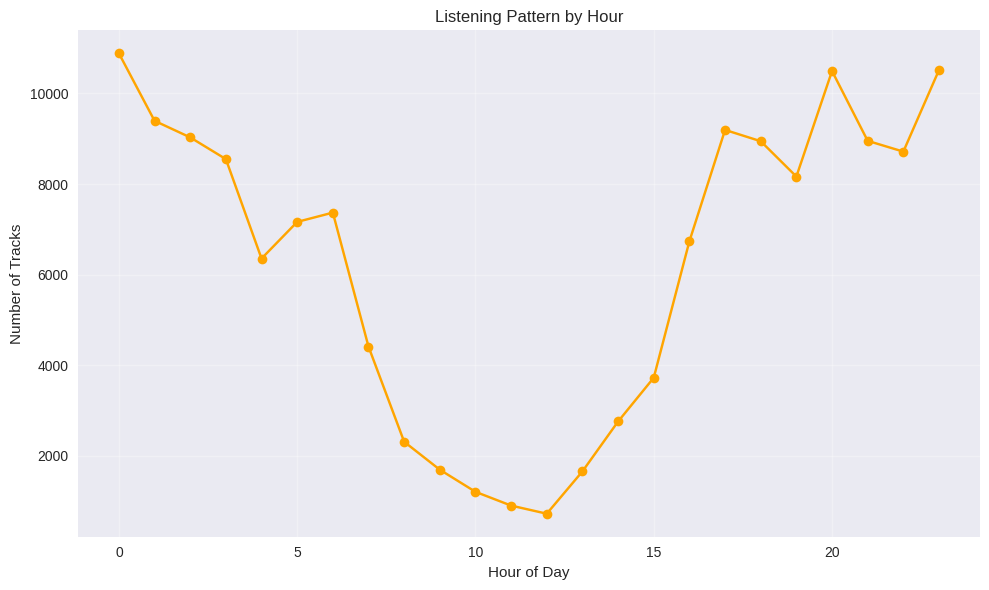

In [18]:
# 3. Hourly listening pattern
plt.figure(figsize=(10, 6))
hourly_data = df.groupby('hour')['track_name'].count()
plt.plot(hourly_data.index, hourly_data.values, marker='o', color='orange')
plt.title('Listening Pattern by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tracks')
plt.grid(True, alpha=0.3)
plt.tight_layout()

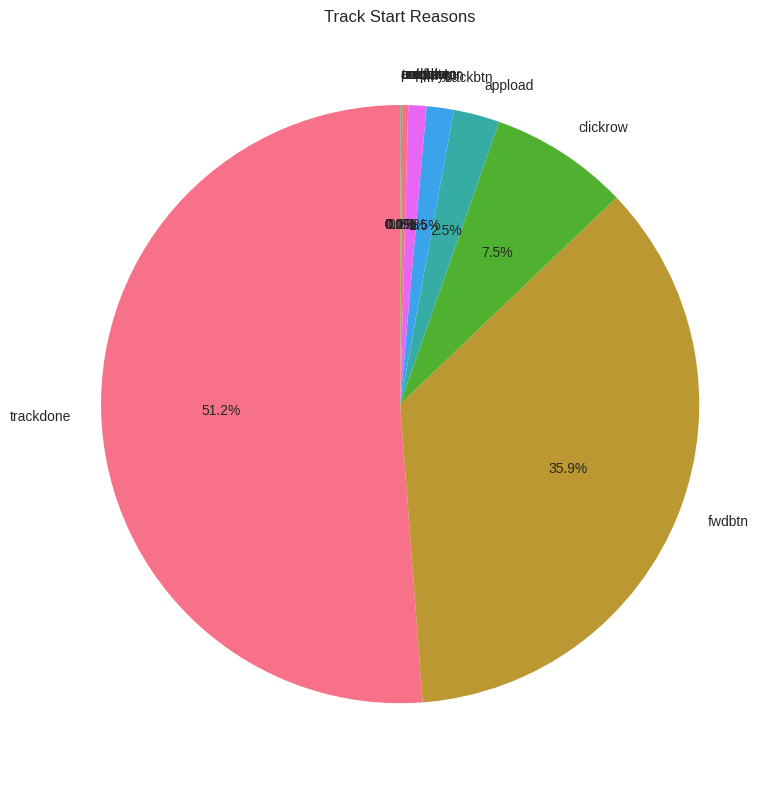

In [19]:
# 4. Reason analysis
plt.figure(figsize=(8, 8))
reason_counts = df['reason_start'].value_counts()
plt.pie(reason_counts.values, labels=reason_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Track Start Reasons')
plt.tight_layout()

In [20]:
# BERT-based Recommendation System

class SpotifyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [21]:
# Recommendation model
class BERTRecommendationModel(nn.Module):
    def __init__(self, num_labels):
        super(BERTRecommendationModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
# Prepare data for BERT
print("Preparing data for BERT model...")

# Create text features combining track, artist, and album info
df['text_features'] = df['track_name'] + ' by ' + df['artist_name'] + ' from ' + df['album_name']

# Create engagement labels based on listening time
# High engagement: > 1 minute, Medium: 10s-1min, Low: < 10s
df['engagement_label'] = pd.cut(
    df['seconds_played'], 
    bins=[-1, 10, 60, float('inf')], 
    labels=['low', 'medium', 'high']
)

# Encode labels
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['engagement_label'])

print(f"Label distribution:")
print(df['engagement_label'].value_counts())
print()

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create embeddings for similarity-based recommendations
print("Creating BERT embeddings for similarity-based recommendations...")

def get_bert_embeddings(texts, tokenizer, model_name='bert-base-uncased'):
    """Get BERT embeddings for texts"""
    model = BertModel.from_pretrained(model_name)
    model.eval()
    
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            # Use CLS token embedding
            embedding = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.append(embedding.flatten())
    
    return np.array(embeddings)

# Get embeddings for all tracks
track_embeddings = get_bert_embeddings(df['text_features'].tolist(), tokenizer)

print(f"Created embeddings with shape: {track_embeddings.shape}")

# Recommendation function
def recommend_songs(query_song_index, embeddings, df, top_k=3):
    """Recommend songs based on similarity to query song"""
    query_embedding = embeddings[query_song_index].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    
    # Get top k similar songs (excluding the query song itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    recommendations = []
    for idx in similar_indices:
        recommendations.append({
            'track': df.iloc[idx]['track_name'],
            'artist': df.iloc[idx]['artist_name'],
            'album': df.iloc[idx]['album_name'],
            'similarity': similarities[idx],
            'engagement': df.iloc[idx]['engagement_label']
        })
    
    return recommendations


Preparing data for BERT model...
Label distribution:
engagement_label
high      89013
low       48950
medium    11897
Name: count, dtype: int64

Creating BERT embeddings for similarity-based recommendations...
Created embeddings with shape: (149860, 768)


In [ ]:
print("6. SONG RECOMMENDATIONS")
print("-" * 50)

# Recommend based on "Born To Die" (index 2)
query_idx = 5
query_song = df.iloc[query_idx]
print(f"Based on your listening to: '{query_song['track_name']}' by {query_song['artist_name']}")
print("Recommended tracks:")

recommendations = recommend_songs(query_idx, track_embeddings, df, top_k=3)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['track']} by {rec['artist']} (similarity: {rec['similarity']:.3f})")

print()

6. SONG RECOMMENDATIONS
--------------------------------------------------
Based on your listening to: 'Born To Die' by Lana Del Rey
Recommended tracks:
1. Summertime Sadness by Lana Del Rey (similarity: 0.943)
2. Young and Beautiful by Lana Del Rey (similarity: 0.938)
3. Video Games by Lana Del Rey (similarity: 0.927)
